### Data

In [2]:
# data
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import altair as alt
import plotly.graph_objects as go
import geopandas as gpd
from sklearn.preprocessing import StandardScaler


data = pd.read_csv('climate_change_impact_on_agriculture_2024.csv')

data.head()

Year Country         Region  Crop_Type  Average_Temperature_C  \
0  2001   India    West Bengal       Corn                   1.55   
1  2024   China          North       Corn                   3.23   
2  2001  France  Ile-de-France      Wheat                  21.11   
3  2001  Canada       Prairies     Coffee                  27.85   
4  1998   India     Tamil Nadu  Sugarcane                   2.19   

   Total_Precipitation_mm  CO2_Emissions_MT  Crop_Yield_MT_per_HA  \
0                  447.06             15.22                 1.737   
1                 2913.57             29.82                 1.737   
2                 1301.74             25.75                 1.719   
3                 1154.36             13.91                 3.890   
4                 1627.48             11.81                 1.080   

   Extreme_Weather_Events  Irrigation_Access_%  Pesticide_Use_KG_per_HA  \
0                       8                14.54                    10.08   
1                       8                11.05                    33.06   
2                       5                84.42                    27.41   
3                       5                94.06                    14.38   
4                       9                95.75                    44.35   

   Fertilizer_Use_KG_per_HA  Soil_Health_Index Adaptation_Strategies  \
0                     14.78              83.25      Water Management   
1                     23.25              54.02         Crop Rotation   
2                     65.53              67.78      Water Management   
3                     87.58              91.39         No Adaptation   
4                     88.08              49.61         Crop Rotation   

   Economic_Impact_Million_USD  
0                       808.13  
1                       616.22  
2                       796.96  
3                       790.32  
4                       401.72

### Initially looking at climate change across the world

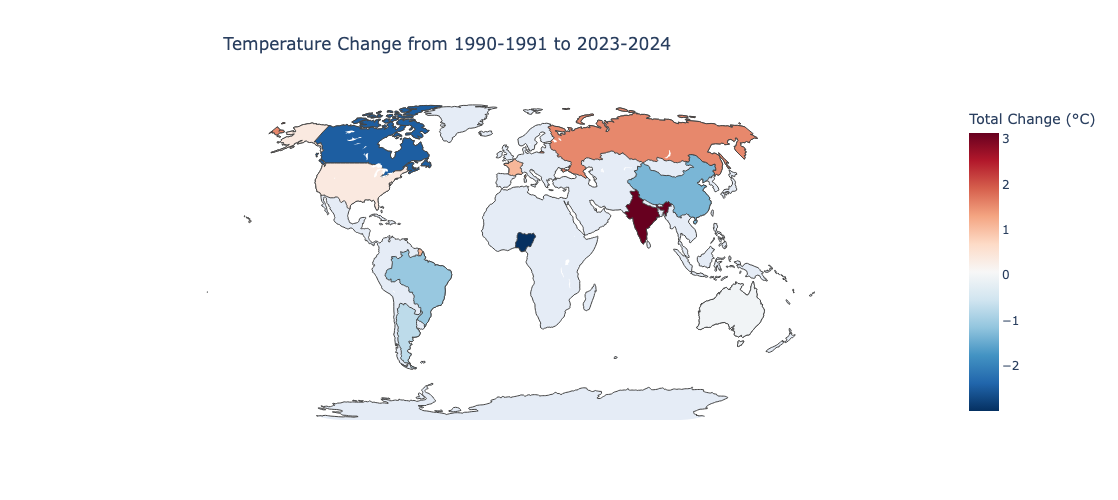

In [3]:
# Ensure Year and Temperature columns are numeric
data["Year"] = pd.to_numeric(data["Year"], errors="coerce")
data = data.dropna(subset=["Year", "Average_Temperature_C", "Country"])

# Filter data for 1990-1991 and 2023-2024, and calculate the mean temperature for each period
data_1990_1991 = data[data["Year"].isin([1990, 1991])].groupby("Country")["Average_Temperature_C"].mean().reset_index()
data_2023_2024 = data[data["Year"].isin([2023, 2024])].groupby("Country")["Average_Temperature_C"].mean().reset_index()

# Merge the 1990-1991 and 2023-2024 average temperature data for each country
temp_change = pd.merge(data_1990_1991, data_2023_2024, on="Country", suffixes=("_1990_1991", "_2023_2024"))

# Calculate the temperature difference between the two periods (2023-2024 - 1990-1991)
temp_change["Total_Change"] = temp_change["Average_Temperature_C_2023_2024"] - temp_change["Average_Temperature_C_1990_1991"]

# Create choropleth map with reversed color scale
fig = px.choropleth(
    temp_change,
    locations="Country",
    locationmode="country names",
    color="Total_Change",
    hover_name="Country",
    title="Temperature Change from 1990-1991 to 2023-2024",
    color_continuous_scale="RdBu_r",  # Reversed color scale: Hotter = Red, Cooler = Blue
    labels={"Total_Change": "Total Change (°C)"}
)

fig.update_layout(
    autosize=True,
    width=None,
    height=500,
    title_x=0.4,
    geo=dict(
        showframe=False,
        showcoastlines=True,
        projection_type="natural earth"
    )
)

fig.show()

fig.write_html('global_temp_change.html')


### Extreme weather changes

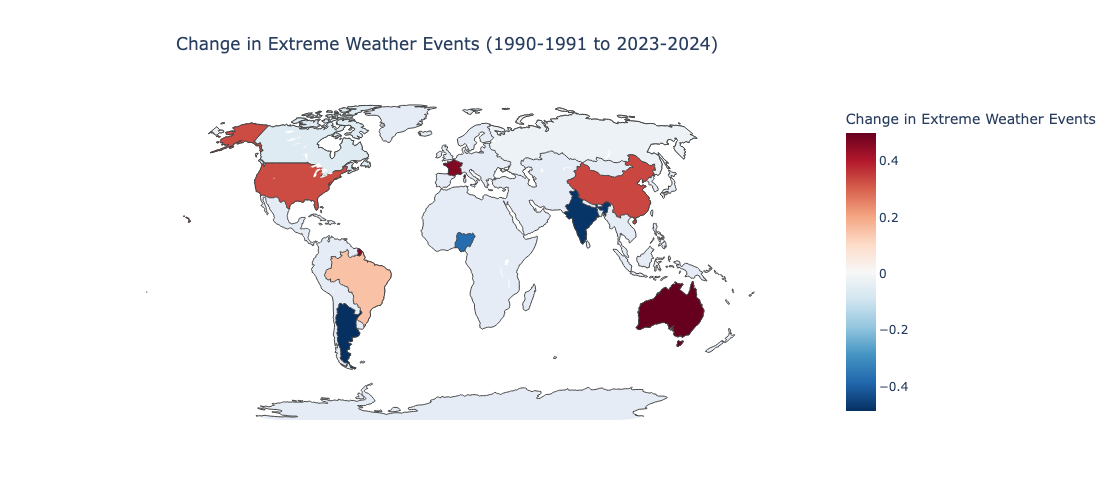

In [4]:
# Ensure Year and Extreme Weather Events columns are numeric
data["Year"] = pd.to_numeric(data["Year"], errors="coerce")
data = data.dropna(subset=["Year", "Extreme_Weather_Events", "Country"])

# Filter data for 1990-1991 and 2023-2024, and calculate the mean number of extreme weather events for each period
data_1990_1991 = data[data["Year"].isin([1990, 1991])].groupby("Country")["Extreme_Weather_Events"].mean().reset_index()
data_2023_2024 = data[data["Year"].isin([2023, 2024])].groupby("Country")["Extreme_Weather_Events"].mean().reset_index()

# Merge the 1990-1991 and 2023-2024 extreme weather data for each country
weather_change = pd.merge(data_1990_1991, data_2023_2024, on="Country", suffixes=("_1990_1991", "_2023_2024"))

# Calculate the change in extreme weather events (2023-2024 - 1990-1991)
weather_change["Total_Change"] = weather_change["Extreme_Weather_Events_2023_2024"] - weather_change["Extreme_Weather_Events_1990_1991"]

# Create choropleth map to show the change in extreme weather events
fig = px.choropleth(
    weather_change,
    locations="Country",
    locationmode="country names",
    color="Total_Change",
    hover_name="Country",
    title="Change in Extreme Weather Events (1990-1991 to 2023-2024)",
    color_continuous_scale="RdBu_r",  # Red (Increase) to Blue (Decrease)
    labels={"Total_Change": "Change in Extreme Weather Events"}
)

fig.update_layout(
    autosize=True,
    width=None,
    height=500,
    title_x=0.4,
    geo=dict(
        showframe=False,
        showcoastlines=True,
        projection_type="natural earth"
    )
)

fig.show()

# Save the plot as an HTML file
fig.write_html('global_extreme_weather_change.html')


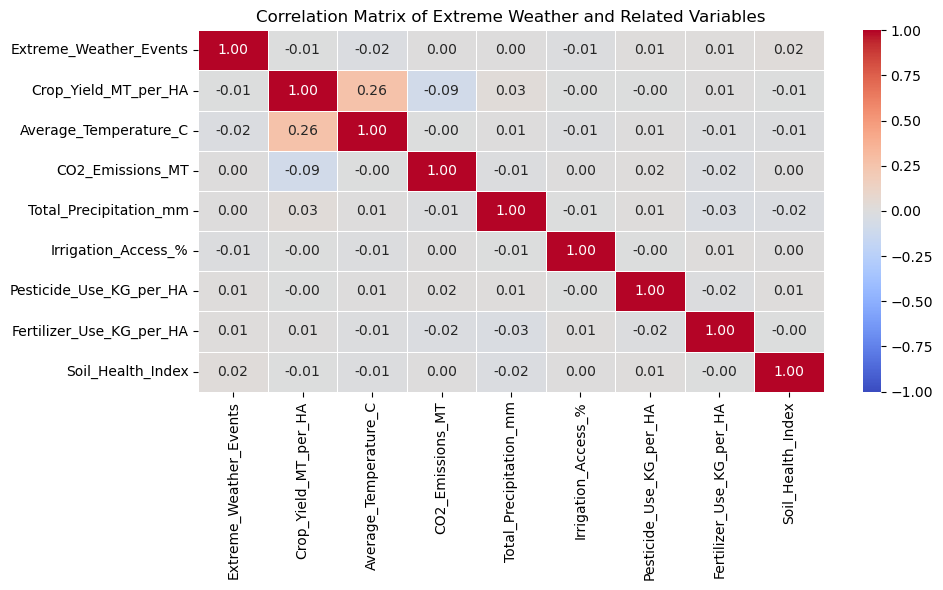

In [5]:
correlation_matrix = data[["Extreme_Weather_Events", "Crop_Yield_MT_per_HA", "Average_Temperature_C", 
                           "CO2_Emissions_MT", "Total_Precipitation_mm", "Irrigation_Access_%", 
                           "Pesticide_Use_KG_per_HA", "Fertilizer_Use_KG_per_HA", "Soil_Health_Index"]].corr()

# Create the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, vmin=-1, vmax=1)

# Add title and adjust layout
plt.title("Correlation Matrix of Extreme Weather and Related Variables")
plt.tight_layout()

# Show the heatmap
plt.savefig('correlation_matrix_heatmap.png', format='png')

plt.show()




### Looking at if temperature affects this and there seems to be ideal temperature around 10-20 degrees celcius

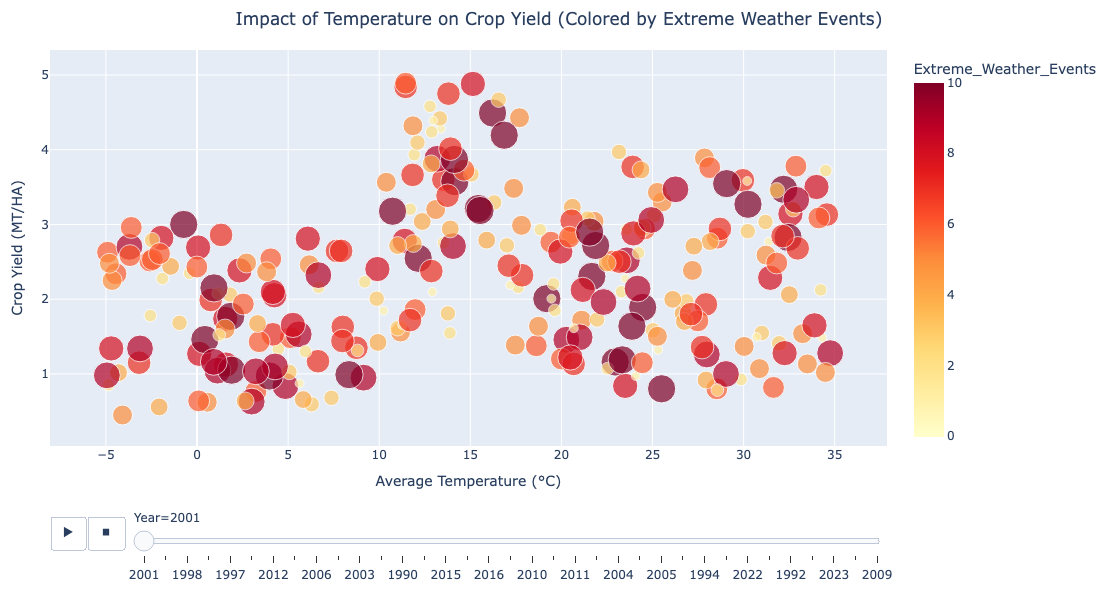

In [6]:
fig = px.scatter(
    data,
    x="Average_Temperature_C",
    y="Crop_Yield_MT_per_HA",
    color="Extreme_Weather_Events",
    size="Extreme_Weather_Events",
    hover_name="Country",
    animation_frame="Year",
    title="Impact of Temperature on Crop Yield (Colored by Extreme Weather Events)",
    color_continuous_scale="YlOrRd",
    labels={
        "Average_Temperature_C": "Average Temperature (°C)",
        "Crop_Yield_MT_per_HA": "Crop Yield (MT/HA)"
    }
)

fig.update_layout(
    width=900,
    height=600,
    title_x=0.5,
    margin=dict(l=50, r=50, t=50, b=50)
)
fig.show()


Correlation between Temperature and Crop Yield: 0.26378072469850977


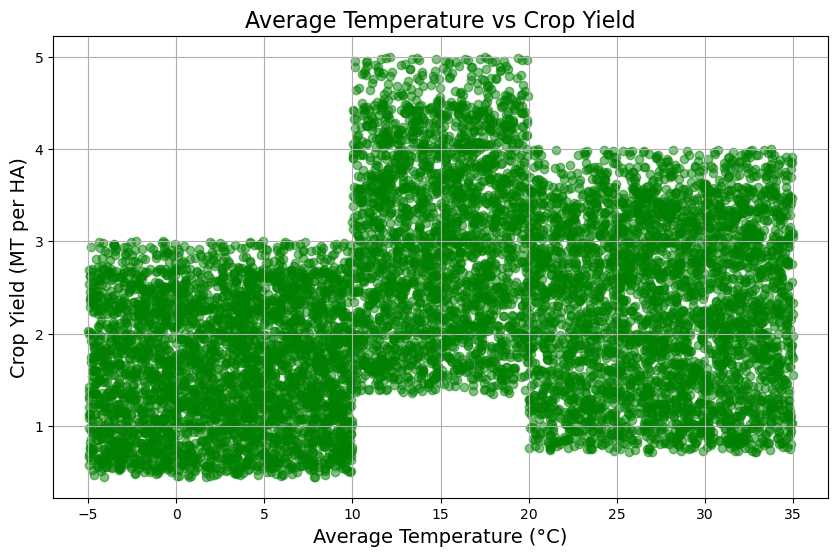

In [7]:
correlation = data['Average_Temperature_C'].corr(data['Crop_Yield_MT_per_HA'])
print(f'Correlation between Temperature and Crop Yield: {correlation}')

# Create a scatter plot of Temperature vs Crop Yield
plt.figure(figsize=(10,6))
plt.scatter(data['Average_Temperature_C'], data['Crop_Yield_MT_per_HA'], alpha=0.5, color='green')
plt.title('Average Temperature vs Crop Yield', fontsize=16)
plt.xlabel('Average Temperature (°C)', fontsize=14)
plt.ylabel('Crop Yield (MT per HA)', fontsize=14)
plt.grid(True)

plt.savefig('temp_crop_yield.png', format='png')

plt.show()


### 3 visualizations below where we try to analyze what drives highest and lowest crop yield while acknowledging the difference is pretty small

In [8]:
pip install --upgrade "vegafusion[embed]>=1.5.0,<2.0" "vegafusion-python-embed>=1.5.0,<2.0"

Note: you may need to restart the kernel to use updated packages.


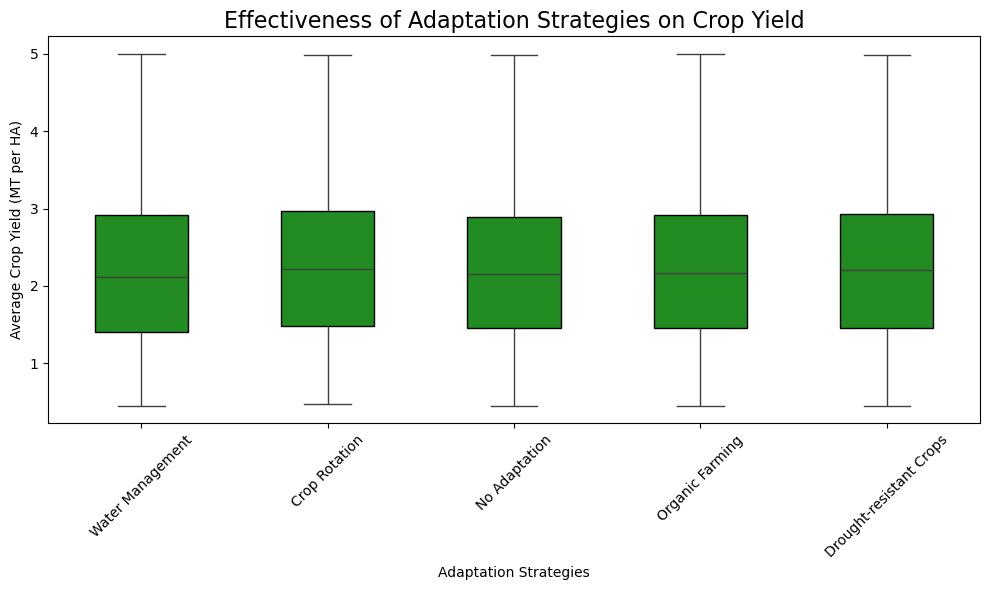

In [9]:
plt.figure(figsize=(10, 6))

sns.boxplot(data=data, x='Adaptation_Strategies', y='Crop_Yield_MT_per_HA', 
            width=0.5, fliersize=5, 
            boxprops=dict(facecolor='forestgreen', edgecolor='black')
           )


plt.title("Effectiveness of Adaptation Strategies on Crop Yield", fontsize=16)
plt.xlabel('Adaptation Strategies')
plt.ylabel('Average Crop Yield (MT per HA)')

plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('cropyield_strategies.png')
plt.show()


### Regional analysis and choosing which countries to look at based on crop yield

In [10]:
data = pd.read_csv('climate_change_impact_on_agriculture_2024.csv')

data['Year'] = data['Year'].astype(int)

# filter data for the years 1990 and 2024
data_filtered = data[(data['Year'] == 1990) | (data['Year'] == 2024)]

# calculate the average crop yield per country in 1990 and 2024
yield_change = data_filtered.groupby(['Country', 'Year'], as_index=False).agg(
    Avg_Crop_Yield=('Crop_Yield_MT_per_HA', 'mean')
)

# split data for 1990 and 2024
yield_1990 = yield_change[yield_change['Year'] == 1990]
yield_2024 = yield_change[yield_change['Year'] == 2024]

# merge two datasets to calculate the percentage change
change = pd.merge(yield_1990[['Country', 'Avg_Crop_Yield']], 
                  yield_2024[['Country', 'Avg_Crop_Yield']], 
                  on='Country', suffixes=('_1990', '_2024'))

# calculate percentage change from 1990 to 2024 for each country
change['Total_Yield_Change_Percentage'] = ((change['Avg_Crop_Yield_2024'] - change['Avg_Crop_Yield_1990']) / change['Avg_Crop_Yield_1990']) * 100

# get top 3 countries with the largest increase in crop yield
top_increase = change.sort_values(by='Total_Yield_Change_Percentage', ascending=False).head(3)

# get the top 3 countries with the largest decrease in crop yield
top_decrease = change.sort_values(by='Total_Yield_Change_Percentage', ascending=True).head(3)

chart_increase = alt.Chart(top_increase).mark_bar(color='forestgreen').encode(
    x=alt.X('Country:N', title='Country'),
    y=alt.Y('Total_Yield_Change_Percentage:Q', title='Total Yield Change (%)')
).properties(
    title='Top 3 Countries with the Largest Increase in Crop Yield (1990-2024)',
    width=300,
    height=400
)

chart_decrease = alt.Chart(top_decrease).mark_bar(color='darkred').encode(
    x=alt.X('Country:N', title='Country'),
    y=alt.Y('Total_Yield_Change_Percentage:Q', title='Total Yield Change (%)')
).properties(
    title='Top 3 Countries with the Largest Decrease in Crop Yield (1990-2024)',
    width=300,
    height=400
)

(chart_increase | chart_decrease)


alt.HConcatChart(...)

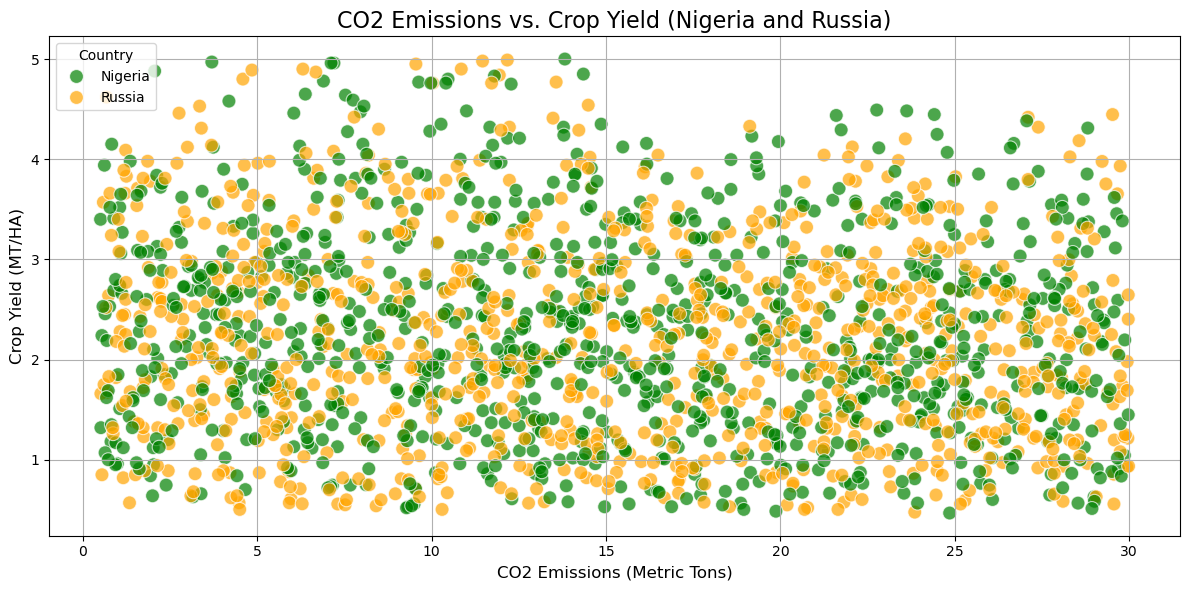

Correlations (CO2 Emissions vs. Crop Yield):
Nigeria: -0.10
Russia: -0.09


In [11]:
# Filter data for Nigeria and Russia
nigeria_russia_data = data[data["Country"].isin(["Nigeria", "Russia"])]

# Scatter plot: CO2 Emissions vs. Crop Yield for Nigeria and Russia
plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=nigeria_russia_data,
    x="CO2_Emissions_MT",
    y="Crop_Yield_MT_per_HA",
    hue="Country",
    palette={"Nigeria": "green", "Russia": "orange"},
    s=100,
    alpha=0.7
)
plt.title("CO2 Emissions vs. Crop Yield (Nigeria and Russia)", fontsize=16)
plt.xlabel("CO2 Emissions (Metric Tons)", fontsize=12)
plt.ylabel("Crop Yield (MT/HA)", fontsize=12)
plt.grid()
plt.legend(title="Country", loc="upper left", fontsize=10)
plt.tight_layout()
plt.show()

# Calculate correlation for each country using Pandas
correlations = {}
for country in ["Nigeria", "Russia"]:
    country_data = nigeria_russia_data[nigeria_russia_data["Country"] == country]
    correlations[country] = country_data["CO2_Emissions_MT"].corr(country_data["Crop_Yield_MT_per_HA"])

# Print correlations
print("Correlations (CO2 Emissions vs. Crop Yield):")
for country, corr in correlations.items():
    print(f"{country}: {corr:.2f}")


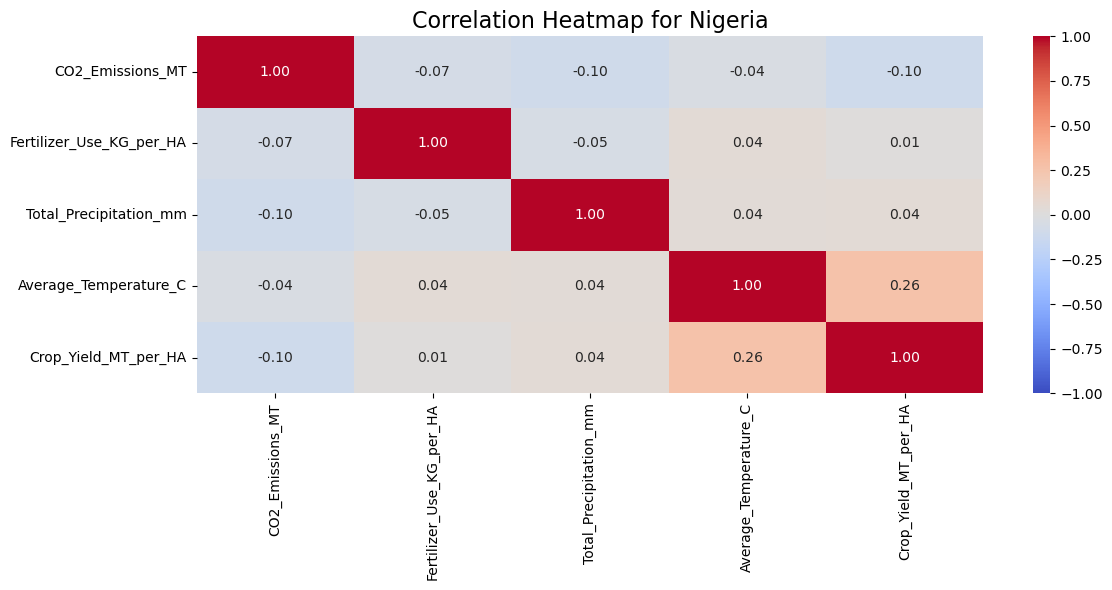

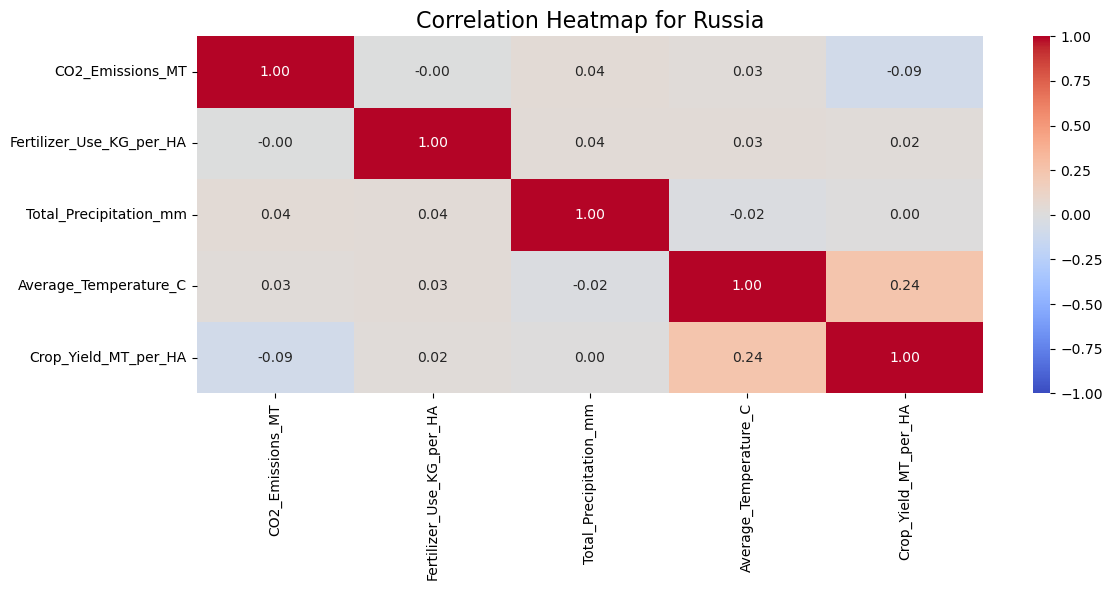

In [12]:
# Filter data for Nigeria and Russia
nigeria_data = nigeria_russia_data[nigeria_russia_data['Country'] == 'Nigeria']
russia_data = nigeria_russia_data[nigeria_russia_data['Country'] == 'Russia']

# Compute the correlation matrices
nigeria_corr_matrix = nigeria_data[['CO2_Emissions_MT', 'Fertilizer_Use_KG_per_HA', 
                                    'Total_Precipitation_mm', 'Average_Temperature_C', 
                                    'Crop_Yield_MT_per_HA']].corr()

russia_corr_matrix = russia_data[['CO2_Emissions_MT', 'Fertilizer_Use_KG_per_HA', 
                                  'Total_Precipitation_mm', 'Average_Temperature_C', 
                                  'Crop_Yield_MT_per_HA']].corr()

# Plot Nigeria correlation heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(nigeria_corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", vmin=-1, vmax=1)
plt.title("Correlation Heatmap for Nigeria", fontsize=16)
plt.tight_layout()
plt.show()

# Plot Russia correlation heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(russia_corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", vmin=-1, vmax=1)
plt.title("Correlation Heatmap for Russia", fontsize=16)
plt.tight_layout()
plt.show()
